# Classificação de Imagens para Diagnóstico Médico

In [11]:
# Importando bibliotecas necessárias
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from PIL import Image


In [12]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input/chest-xray-pneumonia/chest_xray'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [13]:
print(os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray"))

['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [25]:
# Verificando que as imagens estão acessíveis
train_path = os.path.join(dataset_path, "train")
print(os.listdir(train_path))  # Deve listar algo como ['NORMAL', 'PNEUMONIA']


['PNEUMONIA', 'NORMAL']


In [26]:
# definindo os caminhos do dataset
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

In [28]:
# Importando bibliotecas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Definindo um caminho para uma imagem 
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_normal_dir = os.path.join(dataset_path, "train/NORMAL")  # Pasta de imagens normais

# Pegamos o primeiro arquivo da pasta NORMAL
image_file = os.listdir(train_normal_dir)[0]  # Nome do primeiro arquivo
image_path = os.path.join(train_normal_dir, image_file)  # Caminho completo da imagem

print("Visualizando a imagem:", image_path)


Visualizando a imagem: /kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/NORMAL2-IM-0771-0001.jpeg


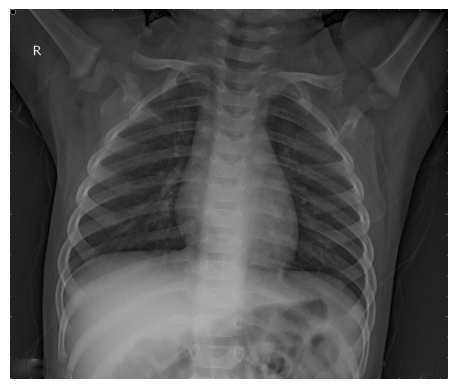

In [29]:
# Exibir a imagem com Matplotlib
# Carregar a imagem

img = mpimg.imread(image_path)

# Exibir a imagem
plt.imshow(img, cmap="gray")  # Como são raios X, a escala de cinza (gray) pode ser útil
plt.axis("off")  # Remove os eixos para melhor visualização
plt.show()

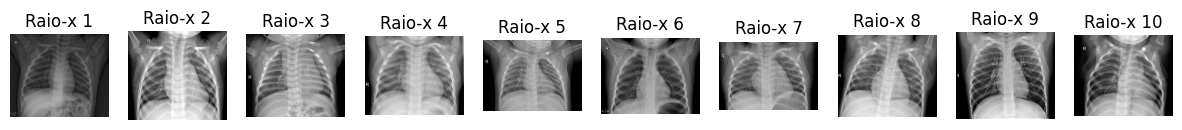

In [46]:
# Exibir múltiplas imagens usando subplots

fig, axes = plt.subplots(1, 10, figsize=(15, 5))  # Criar uma linha com 10 imagens

for i, img_name in enumerate(os.listdir(train_normal_dir)[:10]):  # Pegar as 10 primeiras imagens
    img_path = os.path.join(train_normal_dir, img_name)
    img = mpimg.imread(img_path)  # Carregar a imagem
    
    axes[i].imshow(img, cmap="gray")  # Exibir
    axes[i].axis("off")  # Remover eixos
    axes[i].set_title(f"Raio-x {i+1}")  # Adicionar título

plt.show()

In [38]:
# Pré-processamento das Imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para 224x224 (tamanho usado pelo ResNet)
    transforms.ToTensor(),          # Converte a imagem para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalização
])

# Carregando dados com ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Criando DataLoaders, para alimentar os dados no modelo durante o treinamento
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# **Verificando se os dados foram carregados corretamente:**

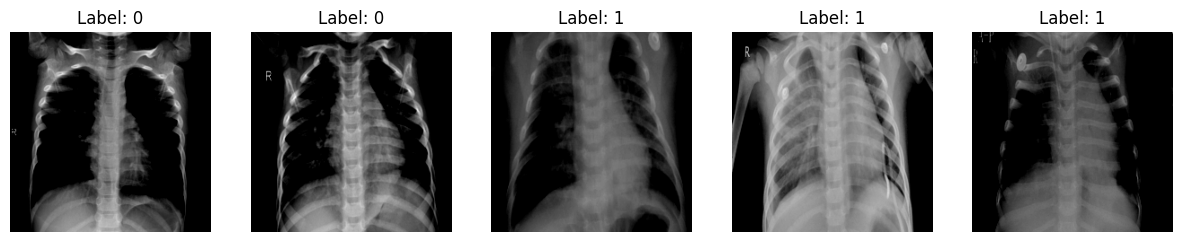

In [39]:
# Carregando dados com ImageFolder
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Criar a Rede Neural Convolucional (CNN)

In [40]:
# usando um modelo pré-treinado do ResNet18 e ajustando para classificar Pneumonia vs Normal.
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Carregar modelo pré-treinado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modificar a camada de saída para 2 classes (Normal e Pneumonia)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# Enviar para GPU, se disponível
model = model.to(device)

Usando dispositivo: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


In [41]:
# definindo função de custo e otimização
criterion = nn.CrossEntropyLoss()  # Função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Otimizador Adam

# Treinamento do Modelo

In [43]:
# Treinando o CNN em 5 épocas

num_epochs = 5

for epoch in range(num_epochs):
    model.train()  # Modo treino
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zera os gradientes
        outputs = model(images)  # Forward
        loss = criterion(outputs, labels)  # Calcula a perda
        loss.backward()  # Backpropagation
        optimizer.step()  # Atualiza os pesos
        
        running_loss += loss.item()
    
    print(f"Época {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Época 1, Loss: 0.0364
Época 2, Loss: 0.0302
Época 3, Loss: 0.0338
Época 4, Loss: 0.0340
Época 5, Loss: 0.0196


# Avaliação do Modelo (Acurácia)

In [44]:
model.eval()  # Modo avaliação
correct = 0
total = 0

with torch.no_grad():  # Desativa o cálculo de gradientes para economizar memória
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Acurácia no conjunto de teste: {100 * correct / total:.2f}%")

Acurácia no conjunto de teste: 76.44%


# Exibindo imagens classificadas

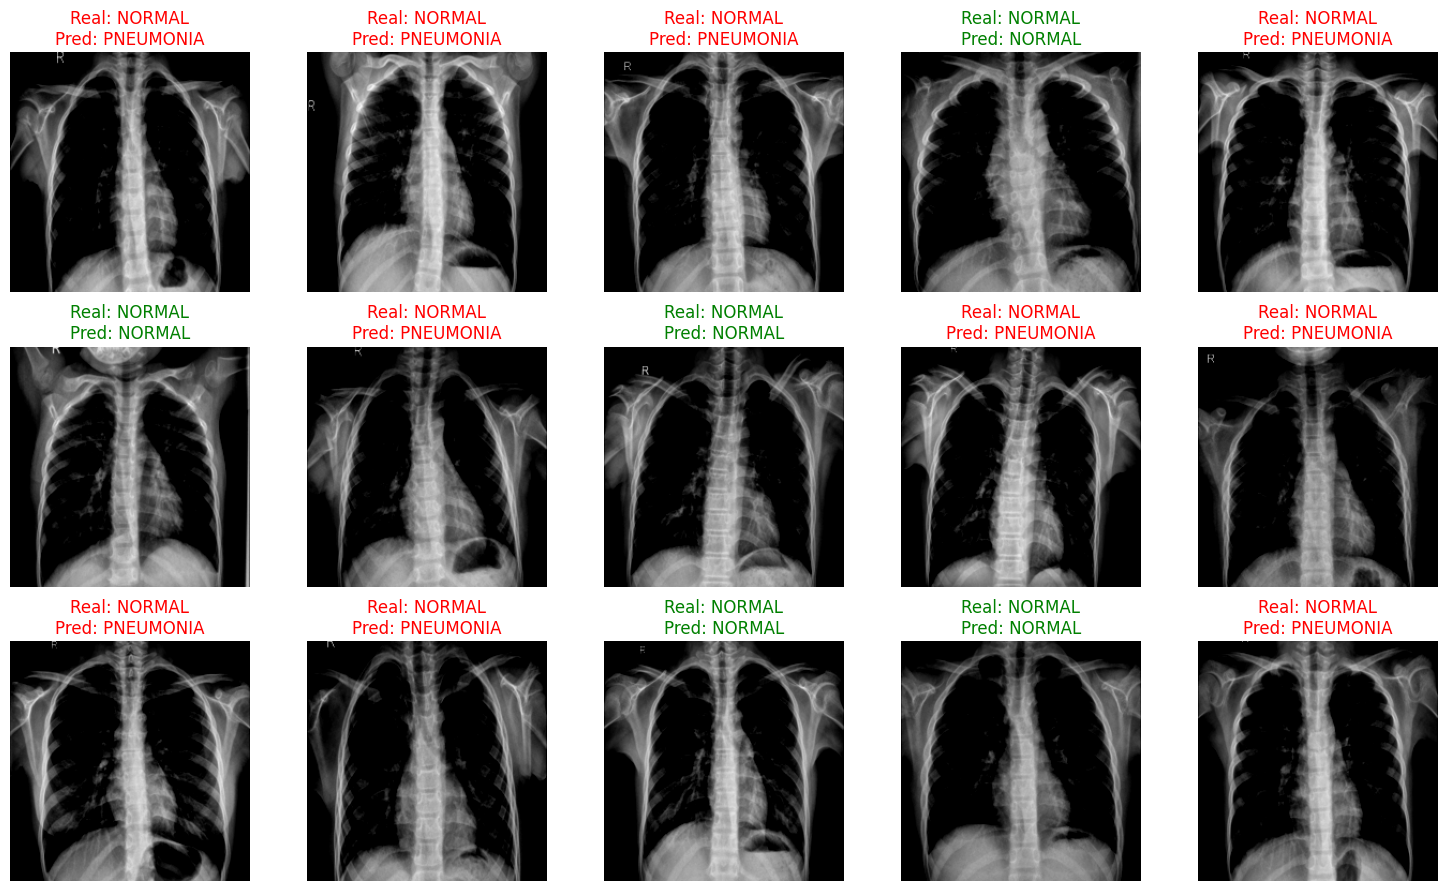

In [47]:
# Definir rótulos (0 = NORMAL, 1 = PNEUMONIA)
class_labels = ["NORMAL", "PNEUMONIA"]

# Obter algumas imagens do conjunto de teste
model.eval()  # Colocar o modelo em modo de avaliação

images, labels = next(iter(test_loader))  # Pegar um lote de imagens do conjunto de teste
images, labels = images.to(device), labels.to(device)

# Fazer previsões
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)  # Pegamos a classe com maior probabilidade

# Converter para CPU e formato NumPy para exibição
images = images.cpu().numpy()

# Criar uma grade para exibir as imagens e previsões
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # 3 linhas, 5 colunas

for i, ax in enumerate(axes.flat):
    if i >= len(images): 
        break
    
    img = np.transpose(images[i], (1, 2, 0))  # Converter de (C, H, W) para (H, W, C)

    true_label = class_labels[labels[i].item()]
    predicted_label = class_labels[predicted[i].item()]
    
    ax.imshow(img, cmap="gray")
    ax.axis("off")
    
    # Se a previsão estiver certa, cor verde, senão, vermelho
    color = "green" if true_label == predicted_label else "red"
    
    ax.set_title(f"Real: {true_label}\nPred: {predicted_label}", color=color, fontsize=12)

plt.tight_layout()
plt.show()